In [60]:
import numpy as np
import matplotlib.pyplot as plt
from math import pi, sqrt, exp
from scipy.integrate import odeint
import scipy.special as sc
%matplotlib inline

In [61]:
#Fonctions de conversion utiles
def s2day(t) :
    '''Conversion de t en seconde vers t en jours'''
    return t/(3600*24)

def s2year(t) :
    '''Conversion de t en seconde vers t en années'''
    return t/(3600*24*365)

#Conversion 1Mpc en m
D_MPc = 3.086e22 

In [62]:
#Constantes physiques
c = 3.e+8           #Vitesse de la lumière 
h = 6.626e-34       #Planck
kb = 1.380e-23      #Boltzmann
Jy = 10.e-26        #1 jansky en SI
sigma = 5.67e-8     #constante de Stefan
a = 4*sigma/c

#Constantes pour le soleil
M_sun = 1.989e+30
R_sun = 696340e+3
L_sun = 3.827e+26


#Paramètre pour le terme de chauffage
A = 6.6e+42/M_sun   
alpha = 1.3

In [63]:
#Constantes du problème
M_ej = 1.e-2*M_sun  #Masse éjectée
v_exp = 0.15*c      #Vitesse d'expension 
R_0 = 1.e+4         #Rayon initial
kappa = 0.5         #Opacité
D = 40*D_MPc

#Constantes du model 
k1 = 1.             #Ajustement du model pour temps radiatif 

In [64]:
#Calcul des temps et longueurs caractéristiques
t_star = sqrt(3*M_ej*kappa/(4*pi*c*v_exp))
R_neb = sqrt(3*M_ej*kappa/(4*pi))
t_neb = R_neb/v_exp

print("Constantes caractéristiques du probleme :")
print("t* = " + str("%.2e"%t_star) + " s = " + str("%.2f"%s2day(t_star)) + " jours")
print("t_neb = " + str("%.2e"%t_neb) + " s = " + str("%.2f"%s2day(t_neb)) + " jours")
print("R_neb = " + str("%.2e"%R_neb) + " m = " + str("%.2f"%(R_neb/R_sun)) + " Rayons solaire")

Constantes caractéristiques du probleme :
t* = 4.19e+05 s = 4.85 jours
t_neb = 1.08e+06 s = 12.53 jours
R_neb = 4.87e+13 m = 69974.01 Rayons solaire


In [65]:
#Rayon de la supernova qui est une fonction affine du temps 
def R(t) :
    return v_exp*t 

### Equation d'évolution de l'ejecta dans la phase d'expansion libre : 
L'équation à résoudre est :

$t_{rad}\frac{dL}{dt} + L(t) = \dot E(t)$

Nous utiliserons odeint de numpy pour sa résolution numérique.

In [66]:
#Dérivée temporelle de l'énergie interne que l'on utilise dans le modèle suivant
def E_dot(t) :
    return A*M_ej*pow(t,-alpha)


#Equation différentielle à résoudre avec odeint
def model(L,t) :
    dLdt = (E_dot(t)-L)*k1*t/pow(t_star,2)
    return dLdt


#Integration de l'équation différentiel pour L(t) sur t dans [0, 1.3*t_neb]
t_list = np.linspace(1.e-6, 1.3*int(t_neb), num=10000)
L0 = 0
L = odeint(model, L0, t_list)

In [67]:
#Expression de l'intensité spécifique (dans un modèle de corps noir)


In [68]:
#Libre parcours moyen des photons en fonction du temps
def l_bar(t) :
    rho = 3*M_ej/(4*pi*pow(R(t),3))
    return 1/(rho*kappa)

#T_list est la liste de la température interne sur un maillage temporel t_list
def T_list(t_list) :
    res = []
    for i in range(len(t_list)) :
        t = t_list[i]
        L_t = L[i]
        T_t = pow(L_t/(4*pi*R(t)*sigma*l_bar(t)),1/4)
        res+= [T_t]
    return res
        
#Ts_list est la liste de la température de surface sur un maillage temporel t_list
def Ts_list(t_list) :
    res=[]
    T = T_list(t_list)
    for i in range(len(t_list)) :
        t = t_list[i]
        T_t = T[i]
        Ts_t = pow(l_bar(t)/R(t),1/4)*T_t
        res+= [Ts_t]
    return res

#P_list est la liste de la pression sur un maillage temporel t_list
def P_list(t_list) :
    T = T_list(t_list)
    return [a*pow(t,4)/3 for t in T]

#U_list est la liste de l'énergie interne sur un maillage temporel t_list
def U_list(t_list) : 
    T = T_list(t_list)
    res = []
    for i in range(len(T)) :
        t = t_list[i]
        Temp = T[i]
        res += [4*pi*pow(R(t),3)*a*pow(Temp,4)/3]
    return res

T = T_list(t_list)
Ts = Ts_list(t_list)
P = P_list(t_list)
U = U_list(t_list)

In [69]:
#Expression de l'intensité spécifique (dans un modèle de corps noir)
def B_list(nu,Ts_arg_list):
    res = []
    for i in range(len(Ts_arg_list)):
        Ts_arg = Ts_arg_list[i]
        Bnu = (2*h*pow(nu,3)/pow(c,2)) / (np.exp((h*nu)/(kb*Ts_arg)) - 1)
        res += [Bnu]
    return res

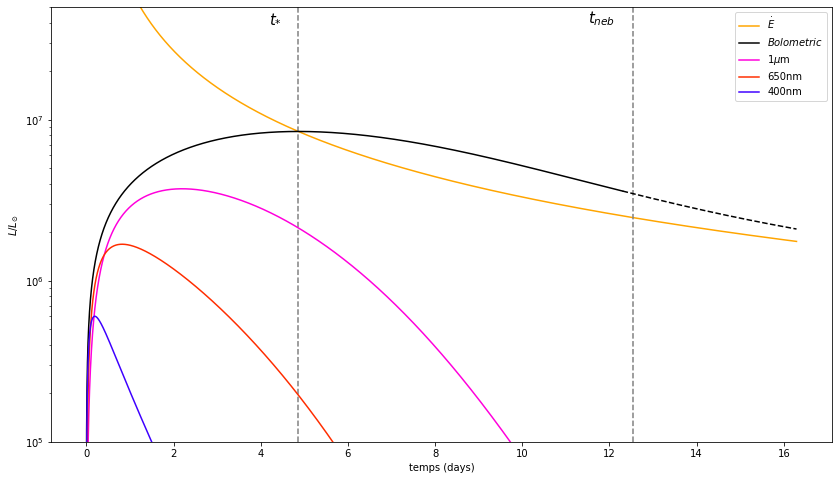

In [70]:
#Représentation grphique de L bolométrique ainsi que L pour différentes longueurs d'ondes

Nlim = 7550 #Utile pour tracer en pointillés après t_neb

plt.figure(figsize=[14,8])
plt.yscale('log')
plt.ylim(1.e5,5.e7)
plt.xlabel('temps (days)')
plt.ylabel('$L/L_{\odot }$')

#Plot de E point
plt.plot(s2day(t_list), E_dot(t_list)/L_sun, color='orange', label='$\dot{E}$')
#Ajout des lignes pointillées pour t_star et t_neb
plt.axvline(x=s2day(t_star),color='gray',linestyle='--')
plt.axvline(x=s2day(t_neb),color='gray',linestyle='--')
#Ajout legende pour t_star et t_neb
plt.text(int(s2day(t_star))+0.2,4.e7,'$t_{*}$',fontsize=15)
plt.text(int(s2day(t_neb)) -0.5,4.e7,'$t_{neb}$',fontsize=15)

#Plot Luminosité bolométrique
plt.plot(s2day(t_list[:Nlim]),L[:Nlim]/L_sun,color='black', label='$Bolometric$')
plt.plot(s2day(t_list[Nlim:]),L[Nlim:]/L_sun,linestyle='--',color='black')

#Plot Luminosité Spécifiques
lambda_Lspecifique = [1000.e-9, 650.e-9, 400.e-9]
color_Lspecifique = ['#FF00DC', '#FF2D00', '#3E00FF']
label_Lspecifique = ['1$\mu$m', '650nm', '400nm']
for i in range (len(lambda_Lspecifique)) :
    lambd = lambda_Lspecifique[i]
    nu = c/lambd
    Bnu = np.array(B_list(nu,Ts[1:]))
    L_specifique = np.array([4*pow(pi,2)*pow(R(t_list[k+1]),2)*Bnu[k] for k in range(len(t)-1)])
    plt.plot(s2day(t_list[:Nlim]),nu*L_specifique[:Nlim]/L_sun,color=color_Lspecifique[i], label = label_Lspecifique[i])
    
plt.legend(loc="upper right")

La figure ci-dessus permet de se rendre compte de plusieurs choses. 

- On voit que entre $t_{star}$ et $t_{neb}$, l'approximation $L = \dot{E}$ est bonne

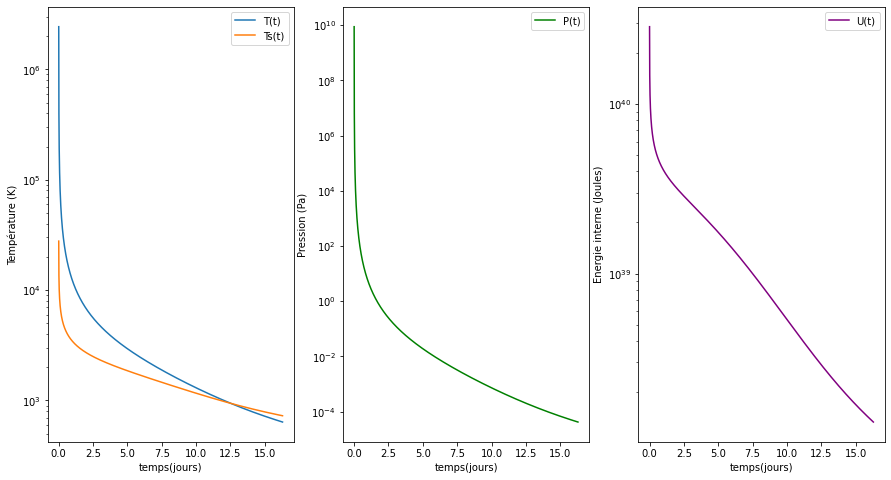

In [71]:
plt.figure(figsize=[15,8])

#Plot de la température 
plt.subplot(131)
plt.xlabel("temps(jours)")
plt.ylabel("Température (K)")
plt.yscale('log')
plt.plot(s2day(t_list[1:]),T[1:],label='T(t)')
plt.plot(s2day(t_list[1:]),Ts[1:],label='Ts(t)')
plt.legend()

#Plot de la Pression
plt.subplot(132)
plt.xlabel("temps(jours)")
plt.ylabel("Pression (Pa)")
plt.yscale('log')
plt.plot(s2day(t_list[1:]),P[1:],label='P(t)',color='green')
plt.legend()

#Plot de l'énergie interne
plt.subplot(133)
plt.xlabel("temps(jours)")
plt.ylabel("Energie interne (Joules)")
plt.yscale('log')
plt.plot(s2day(t_list[1:]),U[1:],label='U(t)',color='purple')
plt.legend()

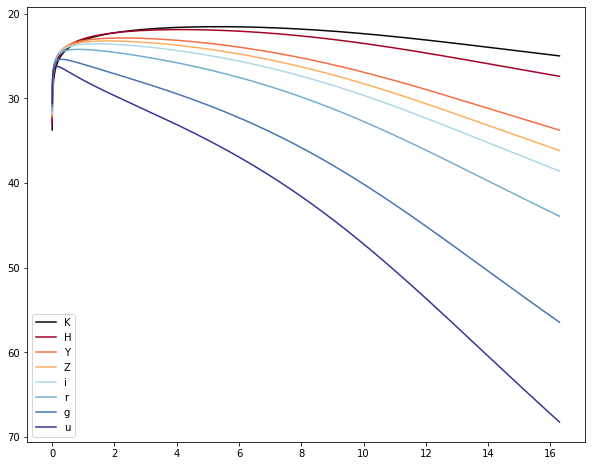

In [73]:
#Longueurs d'ondes et légendes correspondantes
lambd = [2190e-9,1630e-9,1020e-9,900e-9,806e-9,658e-9,464e-9,365e-9]

lettres = ['K','H','Y','Z','i','r','g','u']
colors = [ [8/255,8/255,8/255], [165/255,0/255,38/255], [244/255,109/255,67/255], [253/255,174/255,97/255], [171/255,217/255,233/255], [116/255,173/255,209/255], [69/255,117/255,180/255], [49/255,54/255,149/255] ]


plt.figure(figsize=[10,8])

for i in range(len(lambd)):

    #Intensité spécifique
    nu = c/lambd[i]
    #Bnu = B(nu,Ts[1:]) #Acienne formule utilisée
    Bnu = B_list(nu,Ts)

    #Conversion en jansky et en magnitude AB
    #magAB = [-2.5*np.log( pi*Bnu[i]/(3631*Jy) )/np.log(10) for i in range(len(Bnu))] #Acienne formule utilisée
    magAB = [-2.5*np.log( pi*Bnu[i]*pow((R(t_list[i])/D),2)/(3631*Jy) )/np.log(10) for i in range(len(Bnu))]

    plt.plot(s2day(t_list[1:]),magAB[1:],label=lettres[i], color=colors[i])

plt.gca().invert_yaxis()
plt.legend()